## Convolutional Networks

We'll check out how to build a **convolutional network** to classify CIFAR10 images. By using weight sharing - multiple units with the same weights - convolutional layers are able to learn repeated patterns in your data. For example, a unit could learn the pattern for an eye, or a face, or lower level features like edges.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
def get_train_valid_loader(data_dir='data',
                           batch_size=64,
                           augment=False,
                           random_seed = 1,
                           valid_size=0.2,
                           shuffle=True,
                           show_sample=False,
                           num_workers=0,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid
    multi-process iterators over the CIFAR-10 dataset. A sample
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )

    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=9, shuffle=shuffle,
            num_workers=num_workers, pin_memory=pin_memory,
        )
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy().transpose([0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)

trainloader, valloader = get_train_valid_loader()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3, n_output=10):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        self.kernel_size = 3
        
        self.conv1 = nn.Conv2d(3, 6, self.kernel_size)
        self.conv2 = nn.Conv2d(6, 16, self.kernel_size)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.dropout_conv = nn.Dropout2d(p = 0.2)
        self.dropout_lin = nn.Dropout(p = 0.1)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Tensor `x` with `x.view`.                                                    #
        ################################################################################
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1, 16 * 6 * 6)
        
        x = F.relu(self.fc1(x))
        x = self.dropout_lin(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_lin(x)
        x = self.fc3(x)
        x = self.dropout_lin(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

In [9]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

lr = 0.8
reduction_rate = 0.2
reduce_every = 6

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.002)

epochs = 20
steps = 0

running_loss = 0
correct_train = 0
total_train = 0

train_accs = []
val_accs = []

print_every = 20
evaluate_every_epoch = 1

for e in range(epochs):
    start = time.time()
    
    if (e+1) % reduce_every == 0:
        print('\nReducing Learning rate')
        lr *= reduction_rate
        
    
    for images, labels in iter(trainloader):
        
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        ################################################################################
        net.train()
        optimizer.zero_grad()
        output = net(images)
  
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Count number correct outputs during training
        _, train_pred = torch.max(output, 1)
        total_train += train_pred.size(0)
        correct_train += (train_pred == labels).sum().item()

        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.item()
        """
        if steps % print_every == 0:
            
            net.eval()
            stop = time.time()
            # Test accuracy
            correct = 0
            total = 0
            val_loss = 0
            
            for ii, (images, labels) in enumerate(valloader):
                
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                _, prediction = torch.max(net.predict(images), 1)
                total += prediction.size(0)
                correct += (prediction == labels).sum().item()
                
                output = net(images)
                val_loss += criterion(output, labels).item()
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################

            
            val_accuracy = (correct/total)*100
            val_accs.append(val_accuracy)
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.1f}%".format(val_accuracy), #/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            running_loss = 0
            start = time.time()
            
        """
            
    if e % evaluate_every_epoch == 0:
        # Evaluate train accuracy
        train_accuracy = (correct_train/total_train)*100
        train_accs.append(train_accuracy)
        
        
        # Evaluate test accuracy
        net.eval()
        stop = time.time()
        # Test accuracy
        correct = 0
        total = 0

        for ii, (images, labels) in enumerate(valloader):

            ################################################################################
            # TODO:                                                                        #
            # Calculate the accuracy                                                       #
            ################################################################################
            _, prediction = torch.max(net.predict(images), 1)
            total += prediction.size(0)
            correct += (prediction == labels).sum().item()

            ################################################################################
            #                              END OF YOUR CODE                                #
            ################################################################################


        val_accuracy = (correct/total)*100
        val_accs.append(val_accuracy)

        print("Epoch: {}/{}".format(e+1, epochs),
              "Loss: {:.4f}".format(running_loss/(steps/(e+1))),
              "Train accuracy: {:.1f}%".format(train_accuracy),
              "Test accuracy: {:.1f}%".format(val_accuracy),
              "{:.4f} s/batch".format((stop - start)/print_every)
             )
        running_loss = 0
        correct_train = 0
        total_train = 0
        start = time.time()
        
        

/Users/theo/anaconda3/envs/deep/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20 Loss: 1.7013 Train accuracy: 37.9% Test accuracy: 49.3% 0.6875 s/batch
Epoch: 2/20 Loss: 1.4133 Train accuracy: 49.3% Test accuracy: 55.9% 0.6909 s/batch
Epoch: 3/20 Loss: 1.2972 Train accuracy: 54.1% Test accuracy: 59.0% 0.7174 s/batch
Epoch: 4/20 Loss: 1.2127 Train accuracy: 57.3% Test accuracy: 60.9% 0.7097 s/batch
Epoch: 5/20 Loss: 1.1512 Train accuracy: 59.6% Test accuracy: 61.1% 0.7163 s/batch

Reducing Learning rate
Epoch: 6/20 Loss: 1.1072 Train accuracy: 61.4% Test accuracy: 63.1% 0.7024 s/batch
Epoch: 7/20 Loss: 1.0597 Train accuracy: 62.9% Test accuracy: 63.3% 0.6966 s/batch
Epoch: 8/20 Loss: 1.0234 Train accuracy: 64.2% Test accuracy: 63.9% 0.6983 s/batch


KeyboardInterrupt: 

Save best trained model.

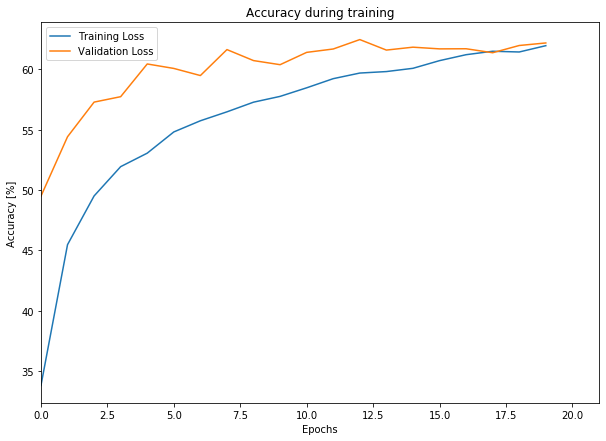

In [8]:

def plot_accuracy(train_accs, val_accs):
    f = plt.figure(figsize = (10, 7))
    x = np.arange(len(train_accs))
    plt.plot(x, train_accs)
    plt.plot(x, val_accs)
    
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.xlim([0,21])
    plt.ylabel('Accuracy [%]')
    plt.show()
    
plot_accuracy(train_accs, val_accs)